In [63]:
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from neo4j import GraphDatabase
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import numpy as np

sns.set(font_scale = 1.5)

### Generate Cypher Projection

@cypher:

    CALL gds.graph.create(
    'KG1',
        ["MeSH", "Document", "Protein", "Drug", "Pathway"],
        {
            MENTIONS: {orientation: 'UNDIRECTED'},
            TARGET: {orientation: 'UNDIRECTED'},
            ASSIGNS: {orientation: 'UNDIRECTED'},
            CANDIDATE: {orientation: 'UNDIRECTED'}
        }
    )

In [64]:
class FastRP():
    """Class to run Node Embedding"""
    def __init__(self) -> None:
        self.driver = GraphDatabase.driver("neo4j://localhost:7687", auth=("neo4j", "heart"))

    def close(self) -> None:
        self.driver.close()
    
    @classmethod
    def run_RP(cls, tx) -> any:
        """
        :param cls: is the class
        :param tx: is the transaction (documented in neo4j)
        :return: result.data() is the embeddings
        """
        query = ("""
        CALL gds.fastRP.stream('KG2',
            {
                embeddingDimension: 256,
                randomSeed: 168
            }
        )
        YIELD nodeId, embedding
        RETURN gds.util.asNode(nodeId).name AS name, LABELS(gds.util.asNode(nodeId)) AS Type, gds.util.asNode(nodeId) AS NodeID, embedding AS Embedding
        """)
        result = tx.run(query)
        return result.data()

    def run_algo(self) -> any:
        """
        :param self:
        :return: result is the dataframe from the degree centrality
        """
        result = self.driver.session().write_transaction(self.run_RP)
        result = pd.DataFrame(result)
        return result

In [65]:
g = FastRP()
rp = g.run_algo()

#editing dataframe
rp["Type"] = rp["Type"].str[0]

In [66]:
rp

,name,Type,NodeID,Embedding
0,Amyloid beta A4 protein,Protein,"{'name': 'Amyloid beta A4 protein', 'id': 'P05...","[0.025802593678236008, 0.027064576745033264, 0..."
1,Matrix metalloproteinase-9,Protein,"{'name': 'Matrix metalloproteinase-9', 'id': '...","[0.12967553734779358, 0.11267309635877609, 0.0..."
2,Voltage-dependent P/Q-type calcium channel sub...,Protein,{'name': 'Voltage-dependent P/Q-type calcium c...,"[-0.03214340656995773, 0.04769778251647949, -0..."
3,Extracellular calcium-sensing receptor,Protein,{'name': 'Extracellular calcium-sensing recept...,"[-0.1362697333097458, 0.18824870884418488, 0.0..."
4,"Nitric oxide synthase, brain",Protein,"{'name': 'Nitric oxide synthase, brain', 'id':...","[-0.12258575111627579, -0.14912813901901245, 0..."
...,...,...,...,...
14768,Metabolism of RNA,Pathway,"{'name': 'Metabolism of RNA', 'id': 'R-HSA-895...","[0.17628909647464752, 0.041342705488204956, -0..."
14769,Metabolism of proteins,Pathway,"{'name': 'Metabolism of proteins', 'id': 'R-HS...","[-0.026170529425144196, 0.05417020246386528, 0..."
14770,Generic Transcription Pathway,Pathway,"{'name': 'Generic Transcription Pathway', 'id'...","[0.05745736137032509, -0.0946069210767746, -0...."
14771,RNA Polymerase II Transcription,Pathway,"{'name': 'RNA Polymerase II Transcription', 'i...","[0.05745736137032509, -0.0946069210767746, -0...."


#### Running t-SNE

In [67]:
tsne = TSNE(n_components=2, n_iter=500)
tsne_results = tsne.fit_transform(rp['Embedding'].to_list())

C:\Users\irsya\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\irsya\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [68]:
rp['tsne_x'] = [x[0] for x in list(tsne_results)]
rp['tsne_y'] = [x[1] for x in list(tsne_results)]

In [69]:
proteins = rp[rp["Type"] == "Protein"]
mesh = rp[rp["Type"] == "MeSH"]
pathway = rp[rp["Type"] == "Pathway"]
doc = rp[rp["Type"] == "Document"]
drug = rp[rp["Type"] == "Drug"]

df = pd.concat([doc, drug, pathway, proteins, mesh])

In [70]:
df

,name,Type,NodeID,Embedding,tsne_x,tsne_y
133,None,Document,"{'date': '{'Year': '2010', 'Month': 'Jul', 'Da...","[-0.1804041862487793, -0.07861331105232239, -0...",16.194189,13.806426
134,None,Document,"{'date': '{'Year': '2018', 'Month': '', 'Day':...","[-0.006899083033204079, -0.11173487454652786, ...",29.904310,-3.409966
135,None,Document,"{'date': '{'Year': '2016', 'Month': '11', 'Day...","[-0.02508184313774109, 0.0727183073759079, 0.0...",4.410931,-0.690772
136,None,Document,"{'date': '{'Year': '2009', 'Month': 'May', 'Da...","[-0.006899083033204079, -0.11173487454652786, ...",29.896606,-3.388757
137,None,Document,"{'date': '{'Year': '2014', 'Month': 'Jun', 'Da...","[-0.08321978896856308, 0.03253558650612831, -0...",-14.472598,4.056190
...,...,...,...,...,...,...
13799,cardiac papillary fibroelastoma,MeSH,"{'name': 'cardiac papillary fibroelastoma', 'i...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",25.615034,14.812422
13800,carney complex,MeSH,"{'name': 'carney complex', 'id': 'C16.131.831....","[0.03725626692175865, 0.009314065799117088, -0...",-2.615537,-7.421929
13801,pericarditis,MeSH,"{'name': 'pericarditis', 'id': 'C14.280.720', ...","[0.13115127384662628, -0.12132679671049118, 0....",10.694075,-37.155018
13802,"pericarditis, constrictive",MeSH,"{'name': 'pericarditis, constrictive', 'id': '...","[-0.18061372637748718, 0.1922612339258194, -0....",-12.659507,8.053080


(-60.0, 60.0)

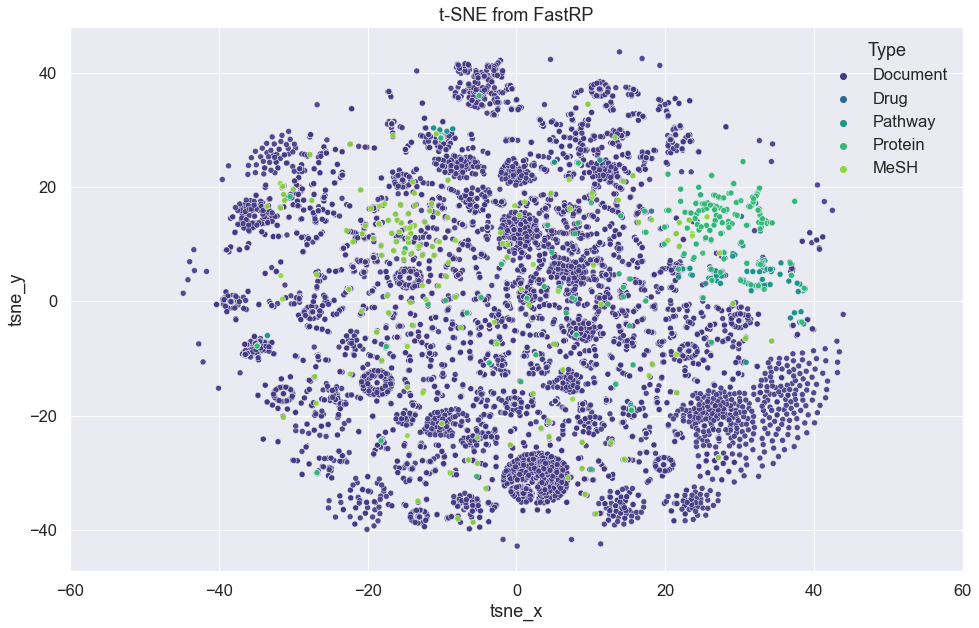

In [176]:
plt.figure(figsize=(16,10))
plt.title("t-SNE from FastRP")
g = sns.scatterplot(
    x="tsne_x", y="tsne_y",
    hue="Type",
    palette="viridis",
    data=df,
    legend="full",
    alpha=0.9
)
g.set_xlim(-60, 60)

In [79]:
plt.savefig("results/tSNE.png")

<Figure size 432x288 with 0 Axes>

In [80]:
df.head()

,name,Type,NodeID,Embedding,tsne_x,tsne_y
133,None,Document,"{'date': '{'Year': '2010', 'Month': 'Jul', 'Da...","[-0.1804041862487793, -0.07861331105232239, -0...",16.194189,13.806426
134,None,Document,"{'date': '{'Year': '2018', 'Month': '', 'Day':...","[-0.006899083033204079, -0.11173487454652786, ...",29.904310,-3.409966
135,None,Document,"{'date': '{'Year': '2016', 'Month': '11', 'Day...","[-0.02508184313774109, 0.0727183073759079, 0.0...",4.410931,-0.690772
136,None,Document,"{'date': '{'Year': '2009', 'Month': 'May', 'Da...","[-0.006899083033204079, -0.11173487454652786, ...",29.896606,-3.388757
137,None,Document,"{'date': '{'Year': '2014', 'Month': 'Jun', 'Da...","[-0.08321978896856308, 0.03253558650612831, -0...",-14.472598,4.056190


#### Using the Elbow Method to Find Clusters

In [129]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from kneed import KneeLocator
from tqdm import tqdm
import seaborn as sns
sns.set(font_scale = 1.5)

In [92]:
kdf = pd.DataFrame([df.tsne_x, df.tsne_y]).transpose()
kdf = kdf.values

kdf

array([[ 16.19419   ,  13.806426  ],
       [ 29.90431   ,  -3.4099658 ],
       [  4.410931  ,  -0.69077206],
       ...,
       [ 10.694075  , -37.155018  ],
       [-12.659507  ,   8.05308   ],
       [-31.174023  ,  17.675846  ]], dtype=float32)

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


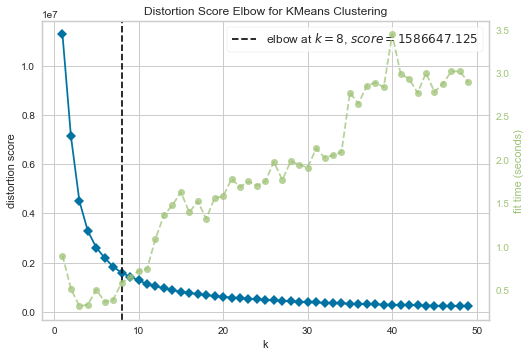

<Figure size 1152x720 with 0 Axes>

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [117]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,50)).fit(kdf)
plt.figure(figsize=(16,10))
visualizer.show()

In [130]:
kmeans = KMeans(n_clusters=7, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(kdf)

In [177]:
df["clusters"] = pred_y
df

,name,Type,NodeID,Embedding,tsne_x,tsne_y,kmeans_y,clusters
133,None,Document,"{'date': '{'Year': '2010', 'Month': 'Jul', 'Da...","[-0.1804041862487793, -0.07861331105232239, -0...",16.194189,13.806426,26,6
134,None,Document,"{'date': '{'Year': '2018', 'Month': '', 'Day':...","[-0.006899083033204079, -0.11173487454652786, ...",29.904310,-3.409966,0,6
135,None,Document,"{'date': '{'Year': '2016', 'Month': '11', 'Day...","[-0.02508184313774109, 0.0727183073759079, 0.0...",4.410931,-0.690772,18,0
136,None,Document,"{'date': '{'Year': '2009', 'Month': 'May', 'Da...","[-0.006899083033204079, -0.11173487454652786, ...",29.896606,-3.388757,0,6
137,None,Document,"{'date': '{'Year': '2014', 'Month': 'Jun', 'Da...","[-0.08321978896856308, 0.03253558650612831, -0...",-14.472598,4.056190,28,2
...,...,...,...,...,...,...,...,...
13799,cardiac papillary fibroelastoma,MeSH,"{'name': 'cardiac papillary fibroelastoma', 'i...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",25.615034,14.812422,10,6
13800,carney complex,MeSH,"{'name': 'carney complex', 'id': 'C16.131.831....","[0.03725626692175865, 0.009314065799117088, -0...",-2.615537,-7.421929,16,0
13801,pericarditis,MeSH,"{'name': 'pericarditis', 'id': 'C14.280.720', ...","[0.13115127384662628, -0.12132679671049118, 0....",10.694075,-37.155018,2,1
13802,"pericarditis, constrictive",MeSH,"{'name': 'pericarditis, constrictive', 'id': '...","[-0.18061372637748718, 0.1922612339258194, -0....",-12.659507,8.053080,28,2


(-60.0, 60.0)

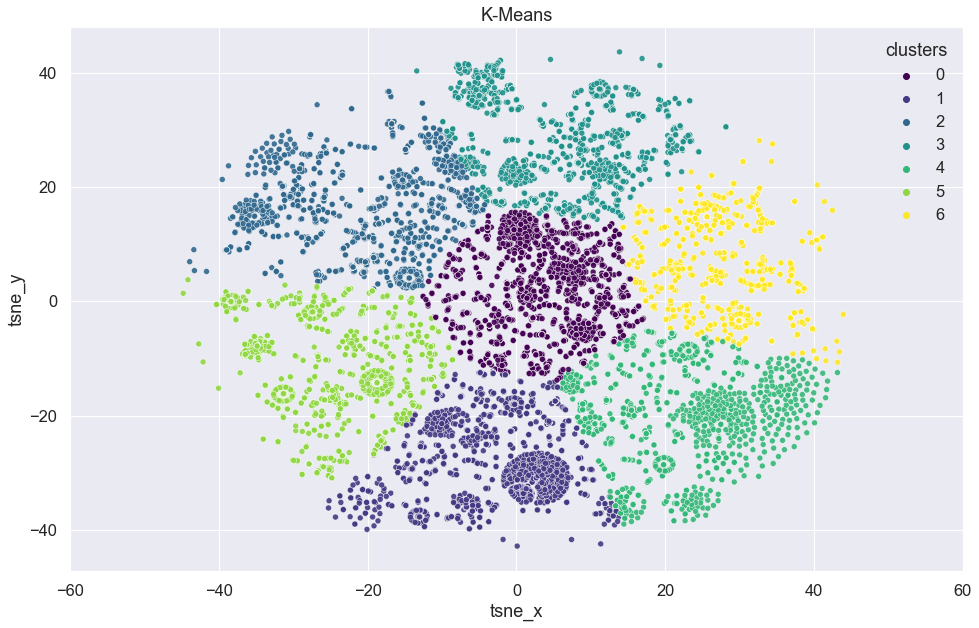

In [180]:
plt.figure(figsize=(16,10))
plt.title("K-Means")
g = sns.scatterplot(
    x="tsne_x", y="tsne_y",
    hue="clusters",
    palette="viridis",
    data=df,
    legend="full",
    alpha=0.9
)
g.set_xlim(-60, 60)

In [135]:
cluster0 = df[df["clusters"] == 0]
cluster1 = df[df["clusters"] == 1]
cluster2 = df[df["clusters"] == 2]
cluster3 = df[df["clusters"] == 3]
cluster4 = df[df["clusters"] == 4]
cluster5 = df[df["clusters"] == 5]
cluster6 = df[df["clusters"] == 6]

In [136]:
mesh0 = cluster0[cluster0["Type"] == "MeSH"]
mesh1 = cluster1[cluster1["Type"] == "MeSH"]
mesh2 = cluster2[cluster2["Type"] == "MeSH"]
mesh3 = cluster3[cluster3["Type"] == "MeSH"]
mesh4 = cluster4[cluster4["Type"] == "MeSH"]
mesh5 = cluster5[cluster5["Type"] == "MeSH"]
mesh6 = cluster6[cluster6["Type"] == "MeSH"]

In [137]:
mesh0

,name,Type,NodeID,Embedding,tsne_x,tsne_y,kmeans_y,clusters
13635,chagas cardiomyopathy,MeSH,"{'name': 'chagas cardiomyopathy', 'id': 'C14.2...","[-0.10348709672689438, -0.0758833959698677, 0....",5.620265,1.771784,18,0
13636,diabetic cardiomyopathies,MeSH,"{'name': 'diabetic cardiomyopathies', 'id': 'C...","[0.007837627083063126, -0.008532645180821419, ...",-8.165241,0.765713,3,0
13637,endocardial fibroelastosis,MeSH,"{'name': 'endocardial fibroelastosis', 'id': '...","[-0.03624597564339638, -0.21133410930633545, -...",-9.158704,6.835675,28,0
13638,isolated noncompaction of the ventricular myoc...,MeSH,{'name': 'isolated noncompaction of the ventri...,"[0.018236074596643448, -0.14457321166992188, -...",10.353514,6.322955,26,0
13642,myocardial reperfusion injury,MeSH,"{'name': 'myocardial reperfusion injury', 'id'...","[-0.009957581758499146, -0.0494784340262413, 0...",6.253043,-11.911629,7,0
13643,myocarditis,MeSH,"{'name': 'myocarditis', 'id': 'C14.280.238.625...","[0.07404069602489471, -0.10443413257598877, 0....",5.114923,-7.468675,7,0
13646,cardio-renal syndrome,MeSH,"{'name': 'cardio-renal syndrome', 'id': 'C14.2...","[-0.04974314942955971, -0.06947968900203705, 0...",-12.172776,0.337397,3,0
13649,"heart failure, diastolic",MeSH,"{'name': 'heart failure, diastolic', 'id': 'C1...","[-0.04826972633600235, 0.02375662513077259, 0....",1.672174,-0.669056,18,0
13657,bradycardia,MeSH,"{'name': 'bradycardia', 'id': 'C23.550.073.300...","[-0.015176542103290558, 0.020371288061141968, ...",-1.266564,7.683722,18,0
13661,ventricular premature complexes,MeSH,"{'name': 'ventricular premature complexes', 'i...","[-0.10632090270519257, -0.024776630103588104, ...",-1.158960,9.911107,5,0


In [138]:
mesh1

,name,Type,NodeID,Embedding,tsne_x,tsne_y,kmeans_y,clusters
13648,"edema, cardiac",MeSH,"{'name': 'edema, cardiac', 'id': 'C23.888.277....","[0.054221220314502716, -0.05743313208222389, -...",3.283979,-22.137564,22,1
13668,sinoatrial block,MeSH,"{'name': 'sinoatrial block', 'id': 'C23.550.07...","[0.016637098044157028, 0.016257237643003464, -...",8.836197,-29.203585,2,1
13679,"tachycardia, paroxysmal",MeSH,"{'name': 'tachycardia, paroxysmal', 'id': 'C23...","[-0.12980563938617706, 0.16169534623622894, -0...",-0.846417,-25.074451,2,1
13686,"tachycardia, sinus",MeSH,"{'name': 'tachycardia, sinus', 'id': 'C23.550....","[-0.0595400333404541, 0.10251219570636749, 0.0...",9.200793,-33.733166,2,1
13691,ventricular flutter,MeSH,"{'name': 'ventricular flutter', 'id': 'C23.550...","[0.05325153470039368, -0.05721785128116608, -0...",-5.830467,-38.598888,9,1
13756,acute coronary syndrome,MeSH,"{'name': 'acute coronary syndrome', 'id': 'C14...","[-0.0025264546275138855, -0.08181171119213104,...",-13.243661,-34.877716,9,1
13757,angina pectoris,MeSH,"{'name': 'angina pectoris', 'id': 'C23.888.592...","[0.0822867900133133, -0.05165563523769379, -0....",-6.492424,-27.736650,25,1
13758,"angina, unstable",MeSH,"{'name': 'angina, unstable', 'id': 'C23.888.59...","[0.09896211326122284, -0.004434720613062382, -...",-5.233356,-23.788145,25,1
13766,coronary stenosis,MeSH,"{'name': 'coronary stenosis', 'id': 'C14.907.5...","[0.11710555106401443, 0.017871631309390068, 0....",-8.888198,-30.012617,25,1
13768,coronary thrombosis,MeSH,"{'name': 'coronary thrombosis', 'id': 'C14.907...","[0.03556523472070694, 0.050709664821624756, 0....",-4.119255,-32.686806,2,1


In [139]:
mesh2

,name,Type,NodeID,Embedding,tsne_x,tsne_y,kmeans_y,clusters
13645,heart failure,MeSH,"{'name': 'heart failure', 'id': 'C14.280.434',...","[-0.09496254473924637, 0.02409336343407631, -0...",-12.649976,2.763551,28,2
13647,"dyspnea, paroxysmal",MeSH,"{'name': 'dyspnea, paroxysmal', 'id': 'C23.888...","[-0.09551092982292175, 0.07436483353376389, -0...",-31.297649,18.696375,8,2
13652,"arrhythmia, sinus",MeSH,"{'name': 'arrhythmia, sinus', 'id': 'C23.550.0...","[-0.043833594769239426, 0.041835833340883255, ...",-13.682751,18.901442,19,2
13654,"sinus arrest, cardiac",MeSH,"{'name': 'sinus arrest, cardiac', 'id': 'C23.5...","[-0.16465717554092407, 0.15023687481880188, 0....",-29.986757,19.620478,8,2
13655,atrial fibrillation,MeSH,"{'name': 'atrial fibrillation', 'id': 'C23.550...","[-0.0029173344373703003, 0.1267981231212616, 0...",-13.929130,20.906151,1,2
...,...,...,...,...,...,...,...,...
13791,heart rupture,MeSH,"{'name': 'heart rupture', 'id': 'C14.280.470',...","[0.0745164304971695, 0.22796359658241272, -0.0...",-31.695009,16.336220,8,2
13793,ventricular septal rupture,MeSH,"{'name': 'ventricular septal rupture', 'id': '...","[-0.019659914076328278, 0.10729070007801056, -...",-33.527115,16.635805,8,2
13798,heart neoplasms,MeSH,"{'name': 'heart neoplasms', 'id': 'C14.280.459...","[-0.05315270647406578, 0.10362287610769272, 0....",-20.941439,19.501425,1,2
13802,"pericarditis, constrictive",MeSH,"{'name': 'pericarditis, constrictive', 'id': '...","[-0.18061372637748718, 0.1922612339258194, -0....",-12.659507,8.053080,28,2


In [140]:
mesh3

,name,Type,NodeID,Embedding,tsne_x,tsne_y,kmeans_y,clusters
13629,arrhythmogenic right ventricular dysplasia,MeSH,{'name': 'arrhythmogenic right ventricular dys...,"[0.03984737768769264, -0.039889004081487656, -...",7.066841,21.281603,4,3
13651,"arrhythmias, cardiac",MeSH,"{'name': 'arrhythmias, cardiac', 'id': 'C23.55...","[-0.07168284803628922, 0.000943794846534729, -...",13.715678,17.737404,24,3
13658,brugada syndrome,MeSH,"{'name': 'brugada syndrome', 'id': 'C16.320.10...","[-0.1287810206413269, 0.04026392847299576, -0....",10.174684,18.303261,5,3
13669,long qt syndrome,MeSH,"{'name': 'long qt syndrome', 'id': 'C23.550.07...","[-0.1610211282968521, -0.060389820486307144, -...",7.178243,16.259918,5,3
13680,"tachycardia, reciprocating",MeSH,"{'name': 'tachycardia, reciprocating', 'id': '...","[0.19817042350769043, 0.09005335718393326, -0....",13.247915,28.682499,29,3
13681,"tachycardia, atrioventricular nodal reentry",MeSH,"{'name': 'tachycardia, atrioventricular nodal ...","[-0.08820022642612457, -0.06618641316890717, 0...",14.357957,20.986191,24,3
13687,"tachycardia, ventricular",MeSH,"{'name': 'tachycardia, ventricular', 'id': 'C2...","[-0.008246021345257759, -0.09790581464767456, ...",-0.240934,16.746605,19,3
13690,ventricular fibrillation,MeSH,"{'name': 'ventricular fibrillation', 'id': 'C2...","[-0.005800716578960419, -0.05457606911659241, ...",1.093093,17.415922,5,3
13704,crisscross heart,MeSH,"{'name': 'crisscross heart', 'id': 'C16.131.24...","[-0.07588910311460495, -0.08818597346544266, 0...",9.604251,34.502972,29,3
13778,cardiac conduction system disease,MeSH,"{'name': 'cardiac conduction system disease', ...","[-0.03795170783996582, 0.022908199578523636, 0...",10.154775,18.899075,5,3


In [141]:
mesh4

,name,Type,NodeID,Embedding,tsne_x,tsne_y,kmeans_y,clusters
13628,cardiomyopathies,MeSH,"{'name': 'cardiomyopathies', 'id': 'C14.280.23...","[-0.014445098116993904, 0.055124178528785706, ...",21.492008,-9.300982,17,4
13632,"cardiomyopathy, hypertrophic",MeSH,"{'name': 'cardiomyopathy, hypertrophic', 'id':...","[0.015165388584136963, -0.014596924185752869, ...",17.814861,-12.944039,17,4
13633,"cardiomyopathy, hypertrophic, familial",MeSH,"{'name': 'cardiomyopathy, hypertrophic, famili...","[0.06679950654506683, 0.0022772406227886677, -...",12.713449,-24.650810,22,4
13634,"cardiomyopathy, restrictive",MeSH,"{'name': 'cardiomyopathy, restrictive', 'id': ...","[0.027473364025354385, 0.09358099102973938, -0...",21.547823,-15.966955,17,4
13740,"aortic stenosis, subvalvular",MeSH,"{'name': 'aortic stenosis, subvalvular', 'id':...","[0.06543636322021484, -0.029038051143288612, -...",7.554713,-17.073238,22,4
13749,pulmonary atresia,MeSH,"{'name': 'pulmonary atresia', 'id': 'C16.131.2...","[0.009295880794525146, -0.10670451819896698, -...",27.145361,-27.291767,11,4
13755,myocardial ischemia,MeSH,"{'name': 'myocardial ischemia', 'id': 'C14.907...","[-0.007580269128084183, -0.059629637748003006,...",18.253418,-10.999932,17,4
13787,heart arrest,MeSH,"{'name': 'heart arrest', 'id': 'C14.280.383', ...","[0.02237863652408123, -0.09828227758407593, 0....",14.474765,-27.570215,11,4


In [142]:
mesh5

,name,Type,NodeID,Embedding,tsne_x,tsne_y,kmeans_y,clusters
13630,"cardiomyopathy, alcoholic",MeSH,"{'name': 'cardiomyopathy, alcoholic', 'id': 'C...","[3.795512020587921e-05, -0.07316098362207413, ...",-18.102177,-10.281466,23,5
13639,endomyocardial fibrosis,MeSH,"{'name': 'endomyocardial fibrosis', 'id': 'C14...","[0.1170111745595932, 0.10208232700824738, -0.1...",-14.614882,-7.811049,3,5
13650,"heart failure, systolic",MeSH,"{'name': 'heart failure, systolic', 'id': 'C14...","[0.14976298809051514, 0.053253207355737686, -0...",-14.248653,-0.203223,3,5
13674,pre-excitation syndromes,MeSH,"{'name': 'pre-excitation syndromes', 'id': 'C1...","[0.16306430101394653, 0.03313606604933739, -0....",-14.672374,-7.874568,3,5
13698,bicuspid aortic valve disease,MeSH,"{'name': 'bicuspid aortic valve disease', 'id'...","[0.09376483410596848, 0.09474684298038483, -0....",-20.805124,-1.685386,14,5
13703,myocardial bridging,MeSH,"{'name': 'myocardial bridging', 'id': 'C16.131...","[0.04353365674614906, -0.15308284759521484, -0...",-31.455711,0.418593,21,5
13723,marfan syndrome,MeSH,"{'name': 'marfan syndrome', 'id': 'C17.300.500...","[0.1326099932193756, 0.05207919329404831, -0.0...",-18.791178,-5.335437,14,5
13738,aortic valve prolapse,MeSH,"{'name': 'aortic valve prolapse', 'id': 'C14.2...","[-0.10777327418327332, 0.07484374940395355, -0...",-22.535088,2.132473,14,5
13739,aortic valve stenosis,MeSH,"{'name': 'aortic valve stenosis', 'id': 'C14.2...","[-0.11302940547466278, 0.13577279448509216, -0...",-17.192009,-1.965515,3,5
13759,"angina pectoris, variant",MeSH,"{'name': 'angina pectoris, variant', 'id': 'C2...","[0.12990935146808624, -0.025084659457206726, -...",-22.358950,-12.677572,23,5


In [144]:
mesh6

,name,Type,NodeID,Embedding,tsne_x,tsne_y,kmeans_y,clusters
13631,"cardiomyopathy, dilated",MeSH,"{'name': 'cardiomyopathy, dilated', 'id': 'C16...","[0.0012508537620306015, -0.08062231540679932, ...",29.100914,-0.353767,0,6
13640,glycogen storage disease type iib,MeSH,"{'name': 'glycogen storage disease type iib', ...","[-0.05727064236998558, -0.033863767981529236, ...",30.778786,-6.469349,0,6
13641,kearns-sayre syndrome,MeSH,"{'name': 'kearns-sayre syndrome', 'id': 'C23.8...","[-0.021473847329616547, -0.08483906835317612, ...",23.630646,11.878220,10,6
13644,sarcoglycanopathies,MeSH,"{'name': 'sarcoglycanopathies', 'id': 'C16.320...","[0.054263725876808167, -0.02217109501361847, -...",34.302933,-6.915908,0,6
13653,sick sinus syndrome,MeSH,"{'name': 'sick sinus syndrome', 'id': 'C23.550...","[-0.11229017376899719, -0.016565365716814995, ...",16.450239,13.862253,26,6
13672,romano-ward syndrome,MeSH,"{'name': 'romano-ward syndrome', 'id': 'C23.55...","[-0.11753500998020172, 0.008769430220127106, -...",18.159456,14.263596,26,6
13673,parasystole,MeSH,"{'name': 'parasystole', 'id': 'C23.550.073.670...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",25.587027,14.819960,10,6
13675,lown-ganong-levine syndrome,MeSH,"{'name': 'lown-ganong-levine syndrome', 'id': ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",25.588392,14.812945,10,6
13676,"pre-excitation, mahaim-type",MeSH,"{'name': 'pre-excitation, mahaim-type', 'id': ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",25.598036,14.798062,10,6
13677,wolff-parkinson-white syndrome,MeSH,"{'name': 'wolff-parkinson-white syndrome', 'id...","[0.03403383865952492, 0.006766239181160927, -0...",23.648893,11.460897,10,6


In [181]:
ls = ["congenital", "heart failure", "heart valve", "pericardial", "cardiomyopathy", "coronary artery", "arrythmia"]
for i in range(len(df["clusters"])):
    df["clusters"][i] = ls[df["clusters"][i]]

df

C:\Users\irsya\AppData\Local\Temp/ipykernel_18732/2743364452.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["clusters"][i] = ls[df["clusters"][i]]


,name,Type,NodeID,Embedding,tsne_x,tsne_y,kmeans_y,clusters
133,None,Document,"{'date': '{'Year': '2010', 'Month': 'Jul', 'Da...","[-0.1804041862487793, -0.07861331105232239, -0...",16.194189,13.806426,26,arrythmia
134,None,Document,"{'date': '{'Year': '2018', 'Month': '', 'Day':...","[-0.006899083033204079, -0.11173487454652786, ...",29.904310,-3.409966,0,arrythmia
135,None,Document,"{'date': '{'Year': '2016', 'Month': '11', 'Day...","[-0.02508184313774109, 0.0727183073759079, 0.0...",4.410931,-0.690772,18,congenital
136,None,Document,"{'date': '{'Year': '2009', 'Month': 'May', 'Da...","[-0.006899083033204079, -0.11173487454652786, ...",29.896606,-3.388757,0,arrythmia
137,None,Document,"{'date': '{'Year': '2014', 'Month': 'Jun', 'Da...","[-0.08321978896856308, 0.03253558650612831, -0...",-14.472598,4.056190,28,heart valve
...,...,...,...,...,...,...,...,...
13799,cardiac papillary fibroelastoma,MeSH,"{'name': 'cardiac papillary fibroelastoma', 'i...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",25.615034,14.812422,10,arrythmia
13800,carney complex,MeSH,"{'name': 'carney complex', 'id': 'C16.131.831....","[0.03725626692175865, 0.009314065799117088, -0...",-2.615537,-7.421929,16,congenital
13801,pericarditis,MeSH,"{'name': 'pericarditis', 'id': 'C14.280.720', ...","[0.13115127384662628, -0.12132679671049118, 0....",10.694075,-37.155018,2,heart failure
13802,"pericarditis, constrictive",MeSH,"{'name': 'pericarditis, constrictive', 'id': '...","[-0.18061372637748718, 0.1922612339258194, -0....",-12.659507,8.053080,28,heart valve


(-60.0, 60.0)

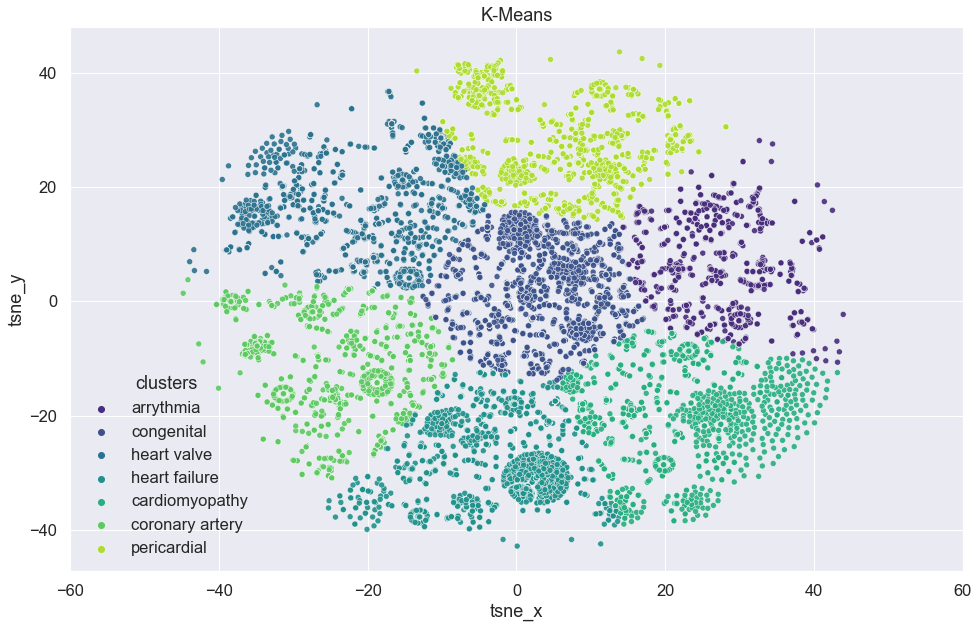

In [182]:
plt.figure(figsize=(16,10))
plt.title("K-Means")
g = sns.scatterplot(
    x="tsne_x", y="tsne_y",
    hue="clusters",
    palette="viridis",
    data=df,
    legend="full",
    alpha=0.9
)
g.set_xlim(-60, 60)